In [ ]:
import pandas as pd
import numpy as np
from pykrx import stock
import matplotlib.pyplot as plt
from datetime import datetime
import datetime
from tqdm import tqdm

import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16,7
plt.rc('font', family='NanumBarunGothic') 

- 흐름
  - 각 분기별 수익률 저장
  - 수익률 평균(3, 5, 상대 등등)
  - 그래프
  - 그룹화
  
- 3,5 일 중 하나랑 상대 수익률 매출 지표별 비교 바 그래프 
- 향후 방향 생각


## Data

#### 기업 딕셔너리

In [ ]:
company_dic = {}
kospi200 = stock.get_index_portfolio_deposit_file("1028") #코스피200종목 리스트
for ticker in kospi200:
        name = stock.get_market_ticker_name(ticker)
        company_dic.update({name:ticker})

#### 상위 20 기업 데이터

## 지표별 수익률 계산

In [ ]:
sales = pd.read_excel('영업이익상위20종목_2011_2020.xlsx', index_col=0)

In [ ]:
quarter_profit = pd.DataFrame() 

for j in tqdm(range(len(sales.columns))):
  try:
    #-- 분기 정보 저장 --#
    quarter = sales[sales.columns[j]]

    date = quarter.apply(lambda x:x[0:8])
    id = quarter.apply(lambda x:company_dic[x[8:]])
    data = pd.DataFrame({'id':id, 'date':date})

    #-- 분기별 수익률 계산 시작 --#
    final_profit_df = pd.DataFrame()

    for i in range(len(data)):
      id, date = data.iloc[i, 0], datetime.datetime.strptime(data.iloc[i, 1], '%Y%m%d').date()

      #-- KOSPI 상위 200개 종목의 2018년 시가 데이터프레임 생성 --#
      market_calender = pd.date_range(str(date), str(date+datetime.timedelta(days=40)), freq='B')

      start_date = str(date+datetime.timedelta(days=-40)).replace('-','')
      end_date = str(date+datetime.timedelta(days=40)).replace('-','')
      ticker_list = [id] 

      price_df = pd.DataFrame(columns=ticker_list, index=market_calender)

      for ticker in ticker_list:
          df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)['시가']
          price_df[ticker] = df

      kospi = stock.get_index_ohlcv_by_date(start_date, end_date, '1001')['시가']

      price_df.dropna(how='all', inplace=True)

      #-- 수익률 계산 --#
      # 3일 수익률
      profit_3 = (price_df.iloc[3] - price_df.iloc[1])*100/price_df.iloc[1]
      # 5일 수익률
      profit_5 = (price_df.iloc[5] - price_df.iloc[1])*100/price_df.iloc[1]
      # 한 달 수익률
      profit_30 = (price_df.iloc[22] - price_df.iloc[1])*100/price_df.iloc[1]

      # 코스피 3일 수익률
      profit_k3 = pd.Series((kospi.iloc[3] - kospi.iloc[1])*100/kospi.iloc[1], index=[id])
      # 코스피 5일 수익률
      profit_k5 = pd.Series((kospi.iloc[5] - kospi.iloc[1])*100/kospi.iloc[1], index=[id])
      # 코스피 한 달 수익률
      profit_k30 = pd.Series((kospi.iloc[22] - kospi.iloc[1])*100/kospi.iloc[1], index=[id])

      # 3일 상대 수익률
      relative_profit_3 = (1 + profit_3)/(1 + profit_k3) - 1
      # 5일 상대 수익률
      relative_profit_5 = (1 + profit_5)/(1 + profit_k5) - 1
      # 한달 상대 수익률
      relative_profit_30 = (1 + profit_30)/(1 + profit_k30) - 1


      #-- 수익률 데이터프레임 생성 --#
      profit_df = pd.DataFrame([profit_3, profit_5, profit_30, profit_k3, profit_k5, profit_k30, relative_profit_3, relative_profit_5, relative_profit_30], 
                  index=['3일 수익률', '5일 수익률', '한 달 수익률', '코스피 3일 수익률', '코스피 5일 수익률', '코스피 한 달 수익률', '3일 상대수익률', '5일 상대수익률', '한 달 상대수익률'])
      
      final_profit_df = pd.concat([final_profit_df, profit_df], axis=1)
    
      #-- 분기별 수익률 데이터프레임 생성 --#
      quarter_profit_one = pd.DataFrame(final_profit_df.mean(axis=1), columns=[sales.columns[j]])
    
    #-- 모든 분기 합친 데이터 프레임 생성 --#
    quarter_profit = pd.concat([quarter_profit, quarter_profit_one], axis=1)
  except:
    pass


100%|██████████| 12/12 [01:43<00:00,  8.59s/it]


In [ ]:
quarter_profit

In [ ]:
quarter_profit_mean = quarter_profit.mean(axis=1)
quarter_profit_mean

3일 수익률         1.205599
5일 수익률         0.870168
한 달 수익률        0.197110
코스피 3일 수익률    -0.147421
코스피 5일 수익률    -0.415299
코스피 한 달 수익률   -1.513812
3일 상대수익률      -3.203024
5일 상대수익률       1.886986
한 달 상대수익률     -1.504934
dtype: float64

## 시각화

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


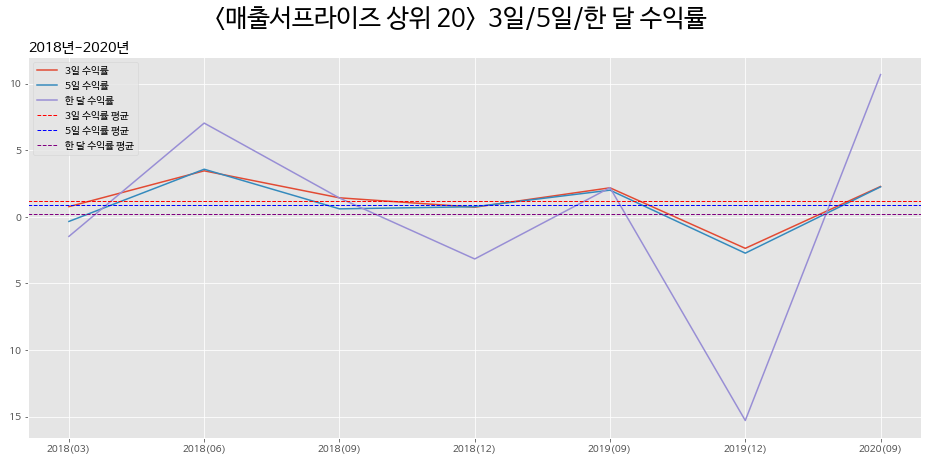

In [ ]:
quarter_for_graph = quarter_profit.loc[['3일 수익률', '5일 수익률', '한 달 수익률'], :].T

quarter_for_graph.plot()
plt.suptitle('<매출서프라이즈 상위 20>  3일/5일/한 달 수익률', fontsize=25)
plt.title('2018년-2020년', loc='left')

plt.axhline(quarter_profit.mean(axis=1)[0], color='red', linestyle='--', linewidth='1', label='3일 수익률 평균')
#plt.text(0, quarter_profit.mean(axis=1)[0], '3일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.axhline(quarter_profit.mean(axis=1)[1], color='blue', linestyle='--', linewidth='1', label='5일 수익률 평균')
#plt.text(1, quarter_profit.mean(axis=1)[1], '5일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.axhline(quarter_profit.mean(axis=1)[2], color='purple', linestyle='--', linewidth='1', label='한 달 수익률 평균')
#plt.text(1, quarter_profit.mean(axis=1)[1], '5일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


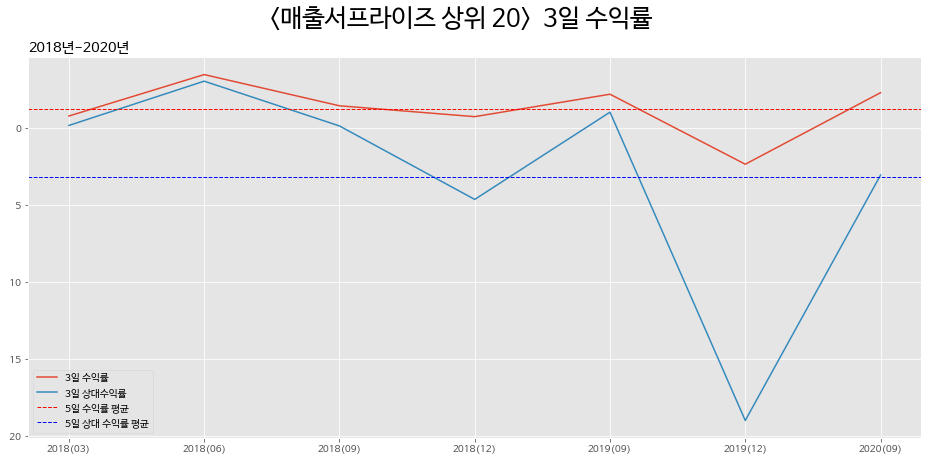

In [ ]:
quarter_for_graph = quarter_profit.loc[['3일 수익률', '3일 상대수익률'], :].T

quarter_for_graph.plot()
plt.suptitle('<매출서프라이즈 상위 20>  3일 수익률', fontsize=25)
plt.title('2018년-2020년', loc='left')

plt.axhline(quarter_profit.mean(axis=1)[0], color='red', linestyle='--', linewidth='1', label='5일 수익률 평균')
#plt.text(0, quarter_profit.mean(axis=1)[0], '3일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.axhline(quarter_profit.mean(axis=1)[6], color='blue', linestyle='--', linewidth='1', label='5일 상대 수익률 평균')
#plt.text(1, quarter_profit.mean(axis=1)[1], '5일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


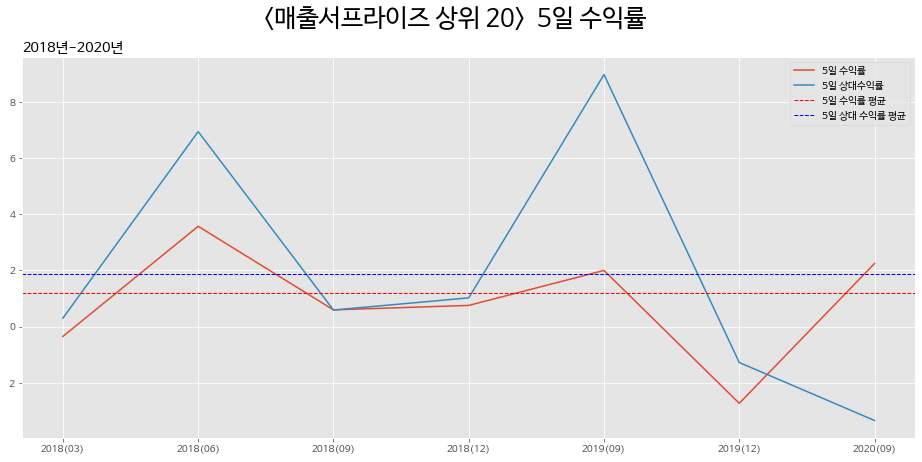

In [ ]:
quarter_for_graph = quarter_profit.loc[['5일 수익률', '5일 상대수익률'], :].T

quarter_for_graph.plot()
plt.suptitle('<매출서프라이즈 상위 20>  5일 수익률', fontsize=25)
plt.title('2018년-2020년', loc='left')

plt.axhline(quarter_profit.mean(axis=1)[0], color='red', linestyle='--', linewidth='1', label='5일 수익률 평균')
#plt.text(0, quarter_profit.mean(axis=1)[0], '3일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.axhline(quarter_profit.mean(axis=1)[7], color='blue', linestyle='--', linewidth='1', label='5일 상대 수익률 평균')
#plt.text(1, quarter_profit.mean(axis=1)[1], '5일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


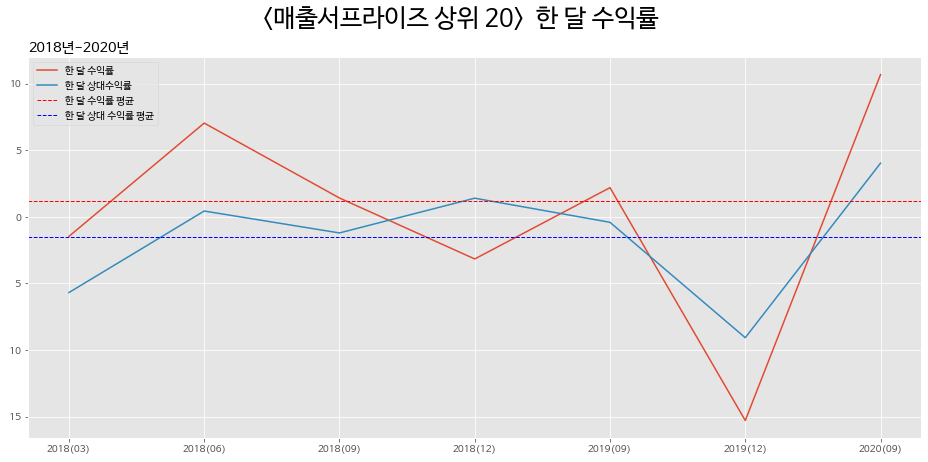

In [ ]:
quarter_for_graph = quarter_profit.loc[['한 달 수익률', '한 달 상대수익률'], :].T

quarter_for_graph.plot()
plt.suptitle('<매출서프라이즈 상위 20>  한 달 수익률', fontsize=25)
plt.title('2018년-2020년', loc='left')

plt.axhline(quarter_profit.mean(axis=1)[0], color='red', linestyle='--', linewidth='1', label='한 달 수익률 평균')
#plt.text(0, quarter_profit.mean(axis=1)[0], '3일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.axhline(quarter_profit.mean(axis=1)[8], color='blue', linestyle='--', linewidth='1', label='한 달 상대 수익률 평균')
#plt.text(1, quarter_profit.mean(axis=1)[1], '5일 수익률 평균', ha='center', va='center', backgroundcolor='white')

plt.legend()
plt.show()

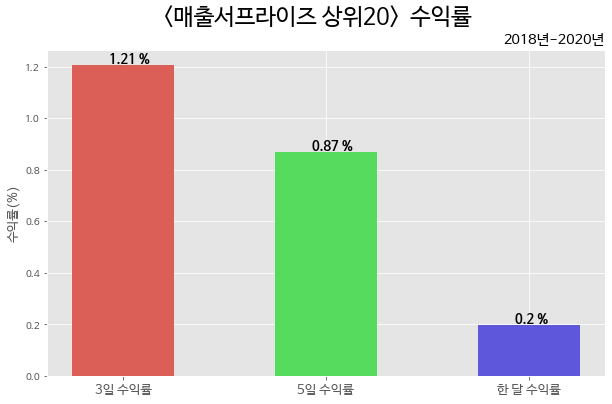

In [ ]:
fig, ax = plt.subplots(figsize = (10,6)) 
colors = sns.color_palette('hls', 3)
x = quarter_profit_mean[0:3]

plt.bar(quarter_profit_mean.index[0:3], quarter_profit_mean[0:3],
        width=0.5, color=colors)
plt.suptitle('<매출서프라이즈 상위20>  수익률', fontsize=23)
plt.title('2018년-2020년', loc='right')
plt.xticks(quarter_profit_mean.index[0:3], fontsize=13)
plt.ylabel('수익률(%)', fontsize=13)

for i, v in enumerate(x):
    ax.text(i-0.07, v+0.01, str(round(v,2))+' %', fontsize=13, fontweight='bold')
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


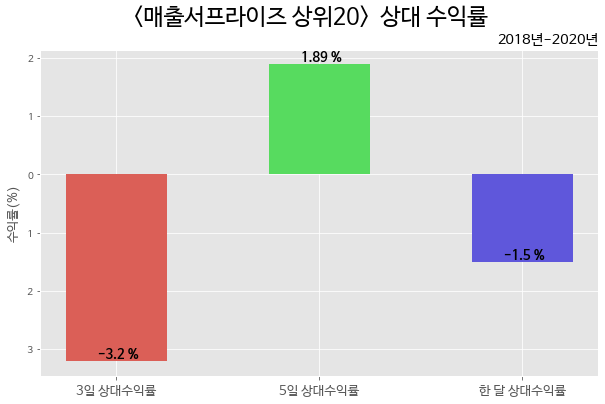

In [ ]:
#plt.figure(figsize = (10,6))
fig, ax = plt.subplots(figsize = (10,6)) 
colors = sns.color_palette('hls', 3)
x = quarter_profit_mean[6:]

plt.bar(quarter_profit_mean.index[6:], quarter_profit_mean[6:],
        width=0.5, color=colors)
plt.suptitle('<매출서프라이즈 상위20>  상대 수익률', fontsize=23)
plt.title('2018년-2020년', loc='right')
plt.xticks(quarter_profit_mean.index[6:], fontsize=13)
plt.ylabel('수익률(%)', fontsize=13)

for i, v in enumerate(x):
    ax.text(i-0.09, v+0.07, str(round(v,2))+' %', fontsize=13, fontweight='bold')
plt.show()